In [1]:
import numpy as np
import gunpowder as gp
from scipy.ndimage import distance_transform_edt as edt
from skimage.metrics import hausdorff_distance
from sklearn.metrics import jaccard_score
from pipeline import random_source_pipeline
import matplotlib.pyplot as plt

In [2]:
# SET SHAPE AND NUMBER OF POINTS HERE
shape = (128, 128, 128) # (z, y, x) shape of the volume
num_points = [shape[0] // 10, shape[0] // 5] # number of random objects in the volume [min, max]
# =====================================

src, req = random_source_pipeline(shape=shape, num_points=num_points)

with gp.build(src):
    batch = src.request_batch(req)
    array = list(batch.arrays.values())[0].data

Shape of volume: (128, 128, 128)
Number of IDs: 17


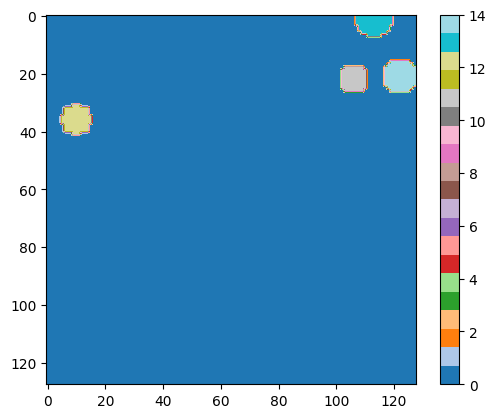

In [3]:
# Plot the GT array and print some info
plt.imshow(array[shape[0]//2], cmap='tab20')
plt.colorbar()

print(f"Shape of volume: {array.shape}\nNumber of IDs: {len(np.unique(array))}")

In [4]:
# Euclidean distance transform on all IDs
%timeit edt(array)

199 ms ± 2.87 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
# Euclidean distance transform on each ID separately
def test(array):
    for id in np.unique(array):
        if id == 0:
            continue
        this = edt(array==id)

%timeit test(array)

3.61 s ± 19.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
# Pairwise Haussdorf distance between individual labels
def h_test(array):
    ids = np.unique(array)
    for i, i1 in enumerate(ids):
        if i1 == 0:
            continue
        for j, i2 in enumerate(ids):
            if j<=i:
                continue
            this = hausdorff_distance(array==i1, array==i2)

%timeit h_test(array)

1.31 s ± 8.02 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
# Pairwise Jaccard distance between overlapping labels
def j_test_fast(array1, array2):
    mean_overlaps = []
    ids1 = np.unique(array1)
    for i1 in ids1:
        if i1 == 0:
            continue
        mask = array1==i1
        ids2 = list(np.unique(array2 * mask))
        ids2.remove(0)
        mean_overlaps.append(len(ids2))
        for i2 in ids2:
            this = jaccard_score(mask.flatten(), (array2==i2).flatten())
    # print(f"Mean # of overlapping IDs: {np.mean(mean_overlaps)}")
%timeit j_test_fast(array, array)

4.61 s ± 28.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
# Pairwise Jaccard distance between all individual labels
def j_test(array):
    ids = np.unique(array)
    for i, i1 in enumerate(ids):
        if i1 == 0:
            continue
        for j, i2 in enumerate(ids):
            if j<=i:
                continue
            this = jaccard_score(array.flatten()==i1, array.flatten()==i2)

%timeit j_test(array)

32.8 s ± 564 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
